# Machine Learning Pipeline

All algorithms

In [282]:
import os
import numpy as np
import pandas as pd
import sklearn as sk
import scipy
from sklearn.metrics import auc, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, brier_score_loss, plot_roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, mutual_info_classif, chi2, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

# import unicodedata # for feature names
import lightgbm

import pickle
from datetime import datetime
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
# define classifiers and hyperparameters

gbdt = lightgbm.LGBMClassifier()

param_grid_gbdt = { 'imputer__n_neighbors' : [1, 5, 10],
              'imputer__weights' : ['distance', 'uniform'],
#               'imputer__weights' : ['distance'],
              'fs__k' : [5,6,7,8,9,10],
              'fs__score_func' : [mutual_info_classif],
              'clf__max_bin': [127, 255, 511],
              'clf__learning_rate': [0.05, 0.1, 0.2, 0.5, 1],
              'clf__num_iterations': [10, 20, 50, 100],
              'clf__boosting': ['gbdt', 'dart']
             }

param_grid_sf_gbdt = { 'imputer__n_neighbors' : [1, 4, 6, 10],
              'imputer__weights' : ['distance', 'uniform'],
#               'imputer__weights' : ['distance'],
              'clf__max_bin': [127, 255, 511],
              'clf__learning_rate': [0.05, 0.1, 0.2, 0.5, 1],
              'clf__num_iterations': [10, 20, 50, 100],
              'clf__boosting': ['gbdt', 'dart']
             }

lr = sk.linear_model.LogisticRegression()

param_grid_lr = { 'imputer__n_neighbors' : [1, 5, 10],
              'imputer__weights' : ['distance', 'uniform'],
              'fs__k' : [5,6,7,8,9,10],
#               'fs__score_func' : [f_classif, mutual_info_classif],
              'fs__score_func' : [mutual_info_classif],
              'clf__C' : [2.0, 1.5, 1.0, 0.5, 0.1, 0.01],
              'clf__class_weight' : ['balanced']
             }

param_grid_sf_lr = { 'imputer__n_neighbors' : [1, 4, 6, 8, 10],
              'imputer__weights' : ['distance', 'uniform'],
              'clf__C' : [2.0, 1.5, 1.0, 0.5, 0.1, 0.01],
              'clf__class_weight' : ['balanced']
             }

knn = sk.neighbors.KNeighborsClassifier()

param_grid_knn = { 
              'imputer__n_neighbors' : [1, 5, 10],
              'imputer__weights' : ['distance'],
              'fs__k' : [5,6,7,8,9,10],
              'fs__score_func' : [mutual_info_classif],
#               'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20],
              'clf__n_neighbors': [1, 5, 8, 10, 12, 15],
                 'clf__p': [0.5, 1, 2],
                 'clf__weights': ['uniform', 'distance']
             }

param_grid_sf_knn = { 
              'imputer__n_neighbors' : [1, 5, 10],
              'imputer__weights' : ['distance'],
              'clf__n_neighbors': [1, 5, 8, 10, 12, 15],
                 'clf__p': [0.5, 1, 2],
                 'clf__weights': ['uniform', 'distance']
             }

gauss = GaussianProcessClassifier()

param_grid_gauss = { 
              'imputer__n_neighbors' : [1, 5, 10],
              'imputer__weights' : ['distance'],
              'fs__k' : [5,6,7,8,9,10],
              'fs__score_func' : [mutual_info_classif],
              'clf__kernel': [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()],
             }

param_grid_sf_gauss = { 
              'imputer__n_neighbors' : [1, 5, 10],
              'imputer__weights' : ['distance'],
              'clf__kernel': [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()],
             }

rf = RandomForestClassifier()

param_grid_rf = { 'imputer__n_neighbors' : [1, 5, 10],
              'imputer__weights' : ['distance'],
              'fs__k' : [5,6,7,8,9,10],
              'fs__score_func' : [mutual_info_classif],
              'clf__n_estimators': [10, 20, 50, 100, 200],
              'clf__min_samples_split' : [2, 4, 8, 16],
              'clf__n_jobs' : [-1],
             }

param_grid_sf_rf = param_grid = { 'imputer__n_neighbors' : [1, 5, 10],
              'imputer__weights' : ['distance'],
              'clf__n_estimators': [10, 20, 50, 100, 200],
              'clf__min_samples_split' : [2, 4, 8, 16],
              'clf__n_jobs' : [-1],
             }

svm = sk.svm.SVC(probability=True)

param_grid_svm = { 'imputer__n_neighbors' : [1, 5, 10],
              'imputer__weights' : ['distance'],
              'fs__k' : [5,6,7,8,9,10],
              'fs__score_func' : [mutual_info_classif],
#               'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'clf__kernel': ['linear', 'rbf', 'sigmoid'],
#              'clf__degree': [1, 2, 3, 4, 5], # only used from poly kernel
#              'clf__gamma': ['scale', 'auto'],
#               'clf__C' : [1.0, 0.9, 0.8, 0.7, 0.5, 0.2],
                'clf__C' : [1.0, 0.5, 0.1],
#               'clf__class_weight' : [None, 'balanced']
             }

param_grid_sf_svm = { 'imputer__n_neighbors' : [1, 5, 10],
              'imputer__weights' : ['distance'],
#               'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'clf__kernel': ['linear', 'rbf', 'sigmoid'],
#              'clf__degree': [1, 2, 3, 4, 5], # only used from poly kernel
#              'clf__gamma': ['scale', 'auto'],
              'clf__C' : [1.0, 0.5, 0.1],
#               'clf__C' : [1.0, 0.9, 0.8, 0.7, 0.5, 0.2, 0.1, 0.05],
#               'clf__class_weight' : [None, 'balanced']
             }

### Helper functions

In [211]:
def years_between_dates(d1, d2):
#     d1 = datetime.strptime(d1, "%Y-%m-%d")
#     d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)/365

def print_CV_result(cv_res, name='Model', round_dec = 4):
    print('\033[1m' + name + '\033[0m', '\t', '(mean, std, min, max)')
    print('===================================================================')
    
    longest_score_name = 0
    
    for score in cv_res.keys():
        if score == 'estimator':
            continue
        else:
            if (len(score)>longest_score_name):
                longest_score_name = len(score)
    
    for score in cv_res.keys():
        if score == 'estimator':
            continue
        else :
            arr = np.array(cv_res[score])
            print('\033[1m' + score + '\033[0m' + int(longest_score_name - len(score))*' ',
                  round(arr.mean(),round_dec),
                  round(arr.std(),round_dec), 
                  round(arr.min(),round_dec),
                  round(arr.max(),round_dec))

def print_gs_params(cv_res):
    for estimator in cv_res['estimator']:
        print ("Best parameters:")
        print(estimator.best_params_)
        print()
        print("Selected Features: ")
        print(list(X.columns[estimator.best_estimator_.named_steps['fs'].get_support()]))
        
def print_proba_score_dist(proba, y, n_bins=20, stacked=True):
    class0 = []
    class1 = []
    for cv_idx, fold in enumerate(y):
        for idx, instance in enumerate(fold):
            if instance == 0:
                class0.append(proba[cv_idx][idx, 1])
            else:
                class1.append(proba[cv_idx][idx, 1])
    
    plt.hist([class0, class1],
            bins=n_bins,
            stacked=stacked,
#                 density = True, 
#     weights = [w_0, w_1],
            label=['ADHD', 'FASD'],
            color=['#445e96', '#eb7575'],
#                 alpha=0.7 # alpha can only be applied to both colours at once!
)
#             plt.ylim(0,1) # problem: each column needs different limits!

    plt.legend()
    plt.show()

def count_selected_features(estimator_list, feature_list, grid_search_result=False):
    selected_features = {fname : 0 for fname in feature_list}
    
    if grid_search_result:
        for e in estimator_list:
            for feature in list(np.array(feature_list)[e.best_estimator_.named_steps['fs'].get_support()]):
                selected_features[feature] += 1
    else :
        for e in estimator_list:
            for feature in list(np.array(feature_list)[e.named_steps['fs'].get_support()]):
                selected_features[feature] += 1

    return selected_features

def run_gs_pipe(X, y, pipe, param_grid, 
                score_to_optimize = 'roc_auc', outer_cv_folds = 10, inner_cv_folds = 10):
    
    scoring = {'precision_macro': precision_score, 
           'recall_macro': recall_score, 
            'specificity': recall_score,
           'f1_macro': f1_score, 
           'accuracy': accuracy_score, 
           'roc_auc': roc_auc_score, 
            'brier': brier_score_loss
          }

    outer_cv = StratifiedKFold(n_splits=outer_cv_folds, shuffle=True, random_state=1)

    results = {s : [] for s in scoring.keys()}

    tprs = []
    aucs = []

    probas = []
    y_tests = []
    estimators = []

    confusion_matrices = {s : [] for s in ['tn', 'tp', 'fn', 'fp']}


    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    fig.set_figheight(6)

    for i, (train, test) in enumerate(outer_cv.split(X, y)):

        # split data
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        # configure the cross-validation procedure
        inner_cv = StratifiedKFold(n_splits=inner_cv_folds, shuffle=True, random_state=1)

        # define search    
        grid_search = GridSearchCV(pipe, 
                               param_grid=param_grid, 
                               scoring=score_to_optimize, 
                               refit=True, 
                               return_train_score=True, 
                               cv=inner_cv,
                               n_jobs=-1)

        # execute search
        search_result = grid_search.fit(X_train, y_train)

        # get the best performing model fit on the whole training set
        best_model = search_result.best_estimator_
        estimators.append(search_result)

        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        yhat_proba = best_model.predict_proba(X_test)
        probas.append(yhat_proba)
        y_tests.append(y_test)

        # evaluate the model and store results

        for score in scoring:
#             brier score and AUC need probability estimations
            if score == 'roc_auc' or score == 'brier':
                results[score].append(scoring[score](y_test, yhat_proba[:, 1]))
            elif score == 'specificity':
                results[score].append(scoring[score](y_test, yhat, pos_label=0))
            else:
                results[score].append(scoring[score](y_test, yhat))

        cm = confusion_matrix(y_test, yhat)
        confusion_matrices['tn'].append(cm[0, 0])
        confusion_matrices['fp'].append(cm[0, 1])
        confusion_matrices['fn'].append(cm[1, 0])
        confusion_matrices['tp'].append(cm[1, 1])

    #     acc = accuracy_score(y_test, yhat)
    #     results.append(acc)

        # ROC curve visualization
        viz = plot_roc_curve(best_model, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        # report progress
    #     print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))

    # # summarize the estimated performance of the model
    # print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

    print_CV_result(results)

    # Print ROC curve

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()
    
    return results, estimators, probas, y_tests, confusion_matrices, fig


# 
# CODE FOR CONFIDENCE INTERVALS
# 

"""
Created on Tue Nov  6 10:06:52 2018

@author: yandexdataschool

Original Code found in:
https://github.com/yandexdataschool/roc_comparison

updated: Raul Sanchez-Vazquez
"""

import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def calc_auc_ci(y_true, y_pred, alpha=0.95):
    auc, auc_cov = delong_roc_variance(y_true, y_pred)
    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    
    if auc_std:
        ci = stats.norm.ppf(
            lower_upper_q,
            loc=auc,
            scale=auc_std)
    else:
        ci = np.array([auc, auc])

    ci[ci > 1] = 1
    return auc, ci

def calc_auc_confidence_intervals(results_dict, alpha=0.95):
    
    auc_ci = dict.fromkeys(results_dict.keys())
    
    for m in results_dict.keys():
        y_tests = results_dict[m]['y_tests']
        y_probas = results_dict[m]['probas']
        
        lower = []
        upper = []
        
        for idx, _ in enumerate(y_tests):
            auc, ci = calc_auc_ci(y_tests[idx], y_probas[idx][:,1])
            lower.append(ci[0])
            upper.append(ci[1])
        tmp_dict = {'lower': lower, 'upper': upper}
        auc_ci[m] = tmp_dict
        
    print ("Average confidence interval limits")
    for key in auc_ci.keys():
        print (key)
        print (round(np.array(auc_ci[key]['lower']).mean(),2), round(np.array(auc_ci[key]['upper']).mean(),2))
    return auc_ci

# Data

In [12]:
data_path = '../../data/adhs-fasd-17032021.xlsx'
missing_values_thresh = 36
mice_iterations = 50

# data = pd.read_excel(data_path)
# on jupyterhub setup, we need openpyxl for reading the data 
data = pd.read_excel(data_path, engine='openpyxl')

# Fix some structural issues and cast data to floats

data['Sex'] = data['Sex'].replace('w', 0)
data['Sex'] = data['Sex'].replace('m', 1)
data['AlterEV'] = data.apply(lambda row : years_between_dates(row['GeburtDatumPatient'], row['DatumErstvorstellung']), axis = 1)

data = data.select_dtypes(
    include=['float64','int64'],
    exclude=['object']
    )

n_missing_nofas = (data[(data.FASDjanein == 0)].isnull().sum() * 100 / len(data[(data.FASDjanein == 0)]))
n_missing_nofas_thresh = set(n_missing_nofas[n_missing_nofas < missing_values_thresh].index)

n_missing_fas = (data[(data.FASDjanein == 1)].isnull().sum() * 100 / len(data[(data.FASDjanein == 1)]))
n_missing_fas_thresh = set(n_missing_fas[n_missing_fas < missing_values_thresh].index)

features_thresh = list(n_missing_fas_thresh.intersection(n_missing_nofas_thresh))

# n_missing_fas_35.union(n_missing_nofas_35).difference(n_missing_fas_35.intersection(n_missing_nofas_35))

# Pipeline

In [33]:
# features that are very easy to assess
light = [    
    'GKUzscore',
    'GGzscore',
    'KgEVzscore', 
    'GLzscore',
    'KLEVzscore', 
    'Gestationsalter',
    'Schlafstörungen', 
    'Para' 
] 

# features that are elaborate to assess
extra = [
     'IQunter85',    
     'psychKomorbiditätjanein',
     'Distanzlos', 
     'GestörteSprache', 
     'Nichtmerkfähig', 
]

extended = light + extra + ['FASDjanein']

In [45]:
# test_transformer = ColumnTransformer(
#     [
#         ("test_selection", "passthrough",
#             [0,3])
#     ],
#     remainder="drop",
# )

# test_transformer2 = ColumnTransformer(
#     [
#         ("test_selection", "drop",
#             [13])
#     ],
#     remainder="passthrough",
# )
# test_df = data[extended].copy().to_numpy()
# data[extended].iloc[10]
# test_transformer2.fit_transform(test_df)[10]

### Pipeline (extended features)

In [55]:
def run_extended_pipe(clf, param_grid):
    features = extended
    X = data[features].to_numpy()
    y = data['FASDjanein'].to_numpy()

    pipe = Pipeline([('scaler', sk.preprocessing.RobustScaler()),
                     ('imputer', KNNImputer(n_neighbors=2, weights="distance")),
                     ('drop_label', ColumnTransformer([("drop_label", "drop", [13])], remainder="passthrough",)),
                     ('fs', SelectKBest(score_func=mutual_info_classif, k=5)),
                     ('clf', clf)])
    results, estimators, probas, y_tests, confusion_matrices, fig = run_gs_pipe(X, y, pipe, param_grid)
    
    return_dict = {
        'scores' : results,
        'estimators' : estimators,
        'probas' : probas,
        'y_tests' : y_tests,
        'confusion_matrices': confusion_matrices,
        'fig' : fig   
    }
    
    return return_dict

In [ ]:
clfs = [lr, knn, gauss, rf, gbdt, svm]
keys = ['lr', 'knn', 'gauss', 'rf', 'gbdt', 'svm']
param_grids = [param_grid_lr,param_grid_knn,param_grid_gauss,param_grid_rf,param_grid_gbdt, param_grid_svm]
results = dict.fromkeys(keys)

for idx, classifier in enumerate(clfs):
    results[keys[idx]] = run_extended_pipe(clfs[idx], param_grids[idx])

In [238]:
score_names = ['roc_auc', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'specificity', 'brier']
results_table = pd.DataFrame(columns = score_names, index=keys)

for model in keys:    
    for score in score_names:
        mean_score = round(np.array(results[model]['scores'][score]).mean(), 2)
        results_table.loc[model][score] = mean_score

results_table

,roc_auc,accuracy,f1_macro,precision_macro,recall_macro,specificity,brier
lr,0.91,0.84,0.86,0.89,0.84,0.82,0.12
knn,0.9,0.84,0.87,0.87,0.88,0.77,0.12
gauss,0.9,0.84,0.87,0.86,0.89,0.75,0.12
rf,0.92,0.85,0.88,0.86,0.91,0.76,0.11
gbdt,0.91,0.85,0.88,0.86,0.91,0.75,0.12
svm,0.9,0.85,0.88,0.85,0.92,0.74,0.12


In [159]:
%%R -i y_tmp -i y_hat_tmp

library(pROC)
roc = roc(y_tmp, y_hat_tmp)
ci(roc)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



95% CI: 0.7572-0.9739 (DeLong)


In [160]:
calc_auc_ci(y_tmp, y_hat_tmp)

(0.8655462184873951, array([0.75723599, 0.97385645]))

In [161]:
results['lr']['scores']['roc_auc'][2]

0.865546218487395

In [212]:
cis = calc_auc_confidence_intervals(results)

Average confidence interval limits
lr
0.83 0.99
knn
0.81 0.99
gauss
0.81 0.99
rf
0.84 0.99
gbdt
0.82 0.99
svm
0.8 0.99


In [91]:
row_names=['10_times', '9_times', '8_times', '7_times']
feat_count_selected = pd.DataFrame(columns = light+extra, index=row_names)

for row in row_names:
    feat_count_selected.loc[row] = 0


for key in keys:
    count = count_selected_features(results[key]['estimators'], light+extra, True)
    for feature in light+extra:
        if count[feature] == 10:
            feat_count_selected.loc['10_times'][feature] += 1
        elif count[feature] == 9:
            feat_count_selected.loc['9_times'][feature] += 1
        if count[feature] == 8:
            feat_count_selected.loc['8_times'][feature] += 1
        elif count[feature] == 7:
            feat_count_selected.loc['7_times'][feature] += 1

feat_count_selected

,GKUzscore,GGzscore,KgEVzscore,GLzscore,KLEVzscore,Gestationsalter,Schlafstörungen,Para,IQunter85,psychKomorbiditätjanein,Distanzlos,GestörteSprache,Nichtmerkfähig
10_times,6,2,0,6,0,0,1,0,6,0,4,0,6
9_times,0,1,0,0,0,0,3,0,0,0,2,0,0
8_times,0,1,1,0,0,0,1,0,0,2,0,0,0
7_times,0,1,2,0,2,0,0,0,0,1,0,0,0


In [396]:
import math

row_names=['10_times', '9_times', '8_times', '7_times', '6_times', '5_times', '4_times', '3_times', '2_times', '1_times', '0_times']
feat_count_selected = pd.DataFrame(columns = light+extra, index=row_names)

for row in row_names:
    feat_count_selected.loc[row] = 0


for key in keys:
    count = count_selected_features(results[key]['estimators'], light+extra, True)
    for feature in light+extra:
        if count[feature] == 10:
   
            feat_count_selected.loc['10_times'][feature] += 1
        elif count[feature] == 9:
            feat_count_selected.loc['9_times'][feature] += 1
        elif count[feature] == 8:
            feat_count_selected.loc['8_times'][feature] += 1
        elif count[feature] == 7:
            feat_count_selected.loc['7_times'][feature] += 1
        elif count[feature] == 6:
            feat_count_selected.loc['6_times'][feature] += 1
        elif count[feature] == 5:
            feat_count_selected.loc['5_times'][feature] += 1
        elif count[feature] == 4:
            feat_count_selected.loc['4_times'][feature] += 1
        elif count[feature] == 3:
            feat_count_selected.loc['3_times'][feature] += 1
        elif count[feature] == 2:
            feat_count_selected.loc['2_times'][feature] += 1
        elif count[feature] == 1:
            feat_count_selected.loc['1_times'][feature] += 1
        elif count[feature] == 0:
            feat_count_selected.loc['0_times'][feature] += 1
            
#         elif count[feature] <= 5:
#             feat_count_selected.loc['<_6_times'][feature] += 1
feat_count_selected.transpose()

,10_times,9_times,8_times,7_times,6_times,5_times,4_times,3_times,2_times,1_times,0_times
GKUzscore,6,0,0,0,0,0,0,0,0,0,0
GGzscore,2,1,1,1,0,0,1,0,0,0,0
KgEVzscore,0,0,1,2,0,2,1,0,0,0,0
GLzscore,6,0,0,0,0,0,0,0,0,0,0
KLEVzscore,0,0,0,2,2,0,0,2,0,0,0
Gestationsalter,0,0,0,0,0,0,0,2,0,3,1
Schlafstörungen,1,3,1,0,0,1,0,0,0,0,0
Para,0,0,0,0,0,0,0,0,2,1,3
IQunter85,6,0,0,0,0,0,0,0,0,0,0
psychKomorbiditätjanein,0,0,2,1,1,0,1,0,0,1,0


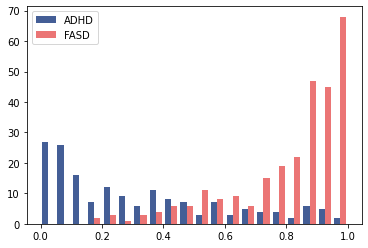

In [367]:
print_proba_score_dist(results['rf']['probas'], results['rf']['y_tests'], 20, False)

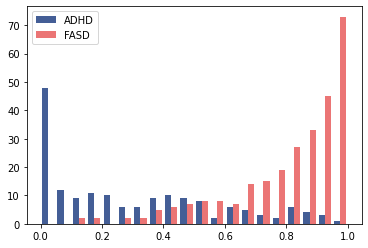

In [368]:
print_proba_score_dist(results_fs6['rf']['probas'], results_fs6['rf']['y_tests'], 20, False)

### Pipeline (selected features)

In [138]:
data[extended].iloc[10]

GKUzscore                  -1.77
GGzscore                   -2.69
KgEVzscore                 -1.37
GLzscore                   -2.13
KLEVzscore                 -1.04
Gestationsalter            39.00
Schlafstörungen             1.00
Para                        1.00
IQunter85                   0.00
psychKomorbiditätjanein     1.00
Distanzlos                  1.00
GestörteSprache             0.00
Nichtmerkfähig              1.00
FASDjanein                  1.00
Name: 10, dtype: float64

In [140]:
column_selector = ColumnTransformer([("fs", "passthrough", [0,3,6,8,10,12])], remainder="drop",)
column_selector.fit_transform(data[extended].copy())[10]

array([-1.77, -2.13,  1.  ,  0.  ,  1.  ,  1.  ])

In [142]:
def run_fs6_pipe(clf, param_grid):
    features = extended
    X = data[features].to_numpy()
    y = data['FASDjanein'].to_numpy()

    pipe = Pipeline([('scaler', sk.preprocessing.RobustScaler()),
                     ('imputer', KNNImputer(n_neighbors=2, weights="distance")),
                     ('select_feats', ColumnTransformer([("fs", "passthrough", [0,3,6,8,10,12])], remainder="drop",)),
                     ('clf', clf)])
    results, estimators, probas, y_tests, confusion_matrices, fig = run_gs_pipe(X, y, pipe, param_grid)
    
    return_dict = {
        'scores' : results,
        'estimators' : estimators,
        'probas' : probas,
        'y_tests' : y_tests,
        'confusion_matrices': confusion_matrices,
        'fig' : fig   
    }
    
    return return_dict

Model 	 (mean, std, min, max)
precision_macro 0.8883 0.0588 0.7857 1.0
recall_macro    0.8108 0.0658 0.6429 0.8929
specificity     0.8235 0.1019 0.6471 1.0
f1_macro        0.8438 0.0301 0.7826 0.8889
accuracy        0.8157 0.0316 0.75 0.8667
roc_auc         0.9046 0.0465 0.8235 0.9727
brier           0.1275 0.02 0.0886 0.1512


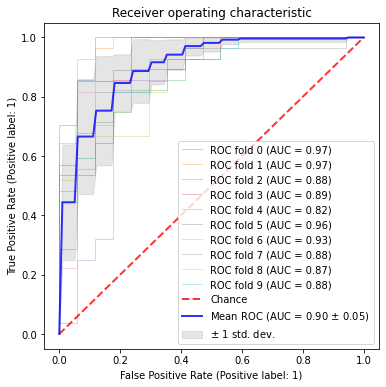

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.73454167 0.73120833 0.733375   0.73454167 0.73120833 0.733375
 0.73308333 0.73704167 0.74616667 0.73308333 0.73704167 0.74616667
        nan        nan        nan        nan        nan        nan
 0.84195521 0.85798125 0.85000312 0.82998542 0.85157917 0.84945521
 0.83364271 0.85611146 0.84453646 0.82669583 0.84699062 0.83983125
        nan        nan        nan        nan        nan        nan
 0.86877187 0.88215625 0.88139688 0.84747917 0.87133021 0.87144479
 0.87102708 0.87720208 0.87340104 0.85090937 0.86475104 0.86417708
        nan        nan        nan        nan        nan        nan
 0.87170521 0.88742396 0.88471458 0.84895833 0.87630625 0.87503542
 0.87324062 0.88003021 0.88047396 0.85222083 0.86820208 0.87074792
        nan        nan        nan    

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.77058333 0.78725    0.78775    0.77058333 0.78725    0.78775
 0.78275    0.7905     0.79033333 0.78275    0.7905     0.79033333
        nan        nan        nan        nan        nan        nan
 0.86374688 0.88896354 0.90124479 0.86529062 0.88720208 0.90439792
 0.86372188 0.88944062 0.88547188 0.86231979 0.88519271 0.89187813
        nan        nan        nan        nan        nan        nan
 0.87900833 0.90846875 0.91022917 0.87929271 0.90608125 0.91240312
 0.87921562 0.89921354 0.89832083 0.87663229 0.89840417 0.90006042
        nan        nan        nan        nan        nan        nan
 0.88732083 0.90929583 0.91207396 0.887075   0.90760625 0.91291146
 0.88171458 0.90128438 0.89398021 0.88098229 0.90014063 0.89688854
        nan        nan        nan     

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.764375   0.78166667 0.789375   0.764375   0.78166667 0.789375
 0.76779167 0.77995833 0.80095833 0.76779167 0.77995833 0.80095833
        nan        nan        nan        nan        nan        nan
 0.87365417 0.87883333 0.88276771 0.87691667 0.8792625  0.88374792
 0.86713229 0.87127812 0.87509687 0.87321458 0.87339375 0.8780875
        nan        nan        nan        nan        nan        nan
 0.88267812 0.89743854 0.89140208 0.88343542 0.8904     0.89155625
 0.88508229 0.88372396 0.8833125  0.88572187 0.88290208 0.88782917
        nan        nan        nan        nan        nan        nan
 0.88531042 0.89933646 0.89833646 0.88861146 0.89431354 0.89836458
 0.88148854 0.88911667 0.89018542 0.88800104 0.8862     0.89140833
        nan        nan        nan     

Model 	 (mean, std, min, max)
precision_macro 0.8658 0.0505 0.8065 0.9545
recall_macro    0.8765 0.0629 0.75 0.9643
specificity     0.7706 0.0965 0.6471 0.9412
f1_macro        0.868 0.0261 0.84 0.9153
accuracy        0.8361 0.0312 0.8 0.8889
roc_auc         0.9112 0.0433 0.833 0.9737
brier           0.1149 0.0217 0.0725 0.1449


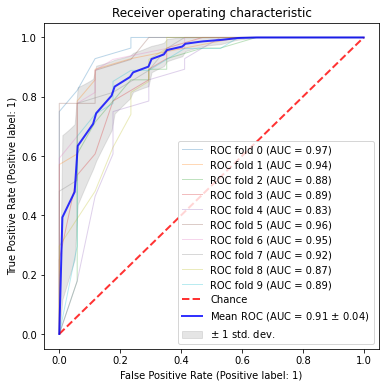

Model 	 (mean, std, min, max)
precision_macro 0.8587 0.0547 0.7812 0.9524
recall_macro    0.8769 0.0804 0.7143 1.0
specificity     0.7588 0.1067 0.5882 0.9412
f1_macro        0.8646 0.0468 0.8 0.9474
accuracy        0.8317 0.0562 0.7556 0.9333
roc_auc         0.9093 0.0508 0.8214 0.979
brier           0.1169 0.0261 0.0657 0.1465


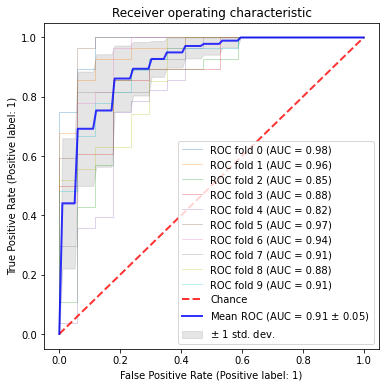

Model 	 (mean, std, min, max)
precision_macro 0.8677 0.0664 0.7647 1.0
recall_macro    0.9056 0.0559 0.7857 1.0
specificity     0.7647 0.1289 0.5294 1.0
f1_macro        0.8834 0.0369 0.8387 0.9492
accuracy        0.8518 0.0501 0.7778 0.9333
roc_auc         0.9263 0.0386 0.8487 0.9847
brier           0.1084 0.0228 0.0651 0.1379


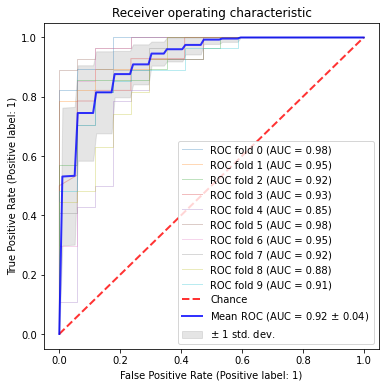

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Model 	 (mean, std, min, max)
precision_macro 0.8691 0.0585 0.7714 1.0
recall_macro    0.8725 0.0829 0.75 1.0
specificity     0.7765 0.1171 0.5294 1.0
f1_macro        0.8668 0.0412 0.7925 0.9492
accuracy        0.8359 0.0481 0.7556 0.9333
roc_auc         0.913 0.0485 0.8298 0.9979
brier           0.1202 0.038 0.0453 0.1879


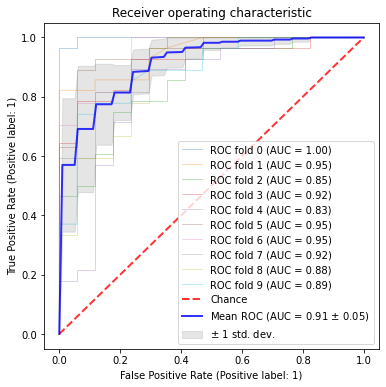

Model 	 (mean, std, min, max)
precision_macro 0.8505 0.0603 0.75 0.9565
recall_macro    0.9052 0.0716 0.7857 1.0
specificity     0.7294 0.1321 0.4706 0.9412
f1_macro        0.8733 0.0347 0.8148 0.931
accuracy        0.8382 0.0448 0.7727 0.9111
roc_auc         0.9006 0.0464 0.8298 0.9622
brier           0.1225 0.0257 0.0759 0.1525


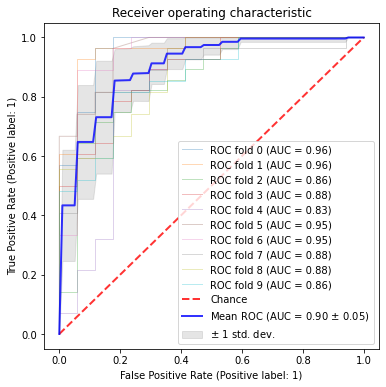

In [147]:
# clfs = [lr, knn, gauss, rf, gbdt, svm]
# keys = ['lr', 'knn', 'gauss', 'rf', 'gbdt', 'svm']
param_grids_sf = [param_grid_sf_lr,param_grid_sf_knn,param_grid_sf_gauss,param_grid_sf_rf,param_grid_sf_gbdt, param_grid_sf_svm]
results_fs6 = dict.fromkeys(keys)

for idx, classifier in enumerate(clfs):
    results_fs6[keys[idx]] = run_fs6_pipe(clfs[idx], param_grids_sf[idx])

In [237]:
score_names = ['roc_auc', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'specificity', 'brier']
results_table_fs6 = pd.DataFrame(columns = score_names, index=keys)

for model in keys:    
    for score in score_names:
        mean_score = round(np.array(results_fs6[model]['scores'][score]).mean(), 2)
        results_table_fs6.loc[model][score] = mean_score

results_table_fs6

,roc_auc,accuracy,f1_macro,precision_macro,recall_macro,specificity,brier
lr,0.9,0.82,0.84,0.89,0.81,0.82,0.13
knn,0.91,0.84,0.87,0.87,0.88,0.77,0.11
gauss,0.91,0.83,0.86,0.86,0.88,0.76,0.12
rf,0.93,0.85,0.88,0.87,0.91,0.76,0.11
gbdt,0.91,0.84,0.87,0.87,0.87,0.78,0.12
svm,0.9,0.84,0.87,0.85,0.91,0.73,0.12


In [426]:
score_names = ['roc_auc', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'specificity', 'brier']
results_table_fs6_r4 = pd.DataFrame(columns = score_names, index=keys)

for model in keys:    
    for score in score_names:
        mean_score = round(np.array(results_fs6[model]['scores'][score]).mean(), 4)
        results_table_fs6_r4.loc[model][score] = mean_score

results_table_fs6_r4

,roc_auc,accuracy,f1_macro,precision_macro,recall_macro,specificity,brier
lr,0.9046,0.8157,0.8438,0.8883,0.8108,0.8235,0.1275
knn,0.9112,0.8361,0.868,0.8658,0.8765,0.7706,0.1149
gauss,0.9093,0.8317,0.8646,0.8587,0.8769,0.7588,0.1169
rf,0.9263,0.8518,0.8834,0.8677,0.9056,0.7647,0.1084
gbdt,0.913,0.8359,0.8668,0.8691,0.8725,0.7765,0.1202
svm,0.9006,0.8382,0.8733,0.8505,0.9052,0.7294,0.1225


In [427]:
score_names = ['roc_auc', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'specificity', 'brier']
results_table_r4 = pd.DataFrame(columns = score_names, index=keys)

for model in keys:    
    for score in score_names:
        mean_score = round(np.array(results[model]['scores'][score]).mean(), 4)
        results_table_r4.loc[model][score] = mean_score

results_table_r4

,roc_auc,accuracy,f1_macro,precision_macro,recall_macro,specificity,brier
lr,0.9107,0.836,0.8636,0.8908,0.8438,0.8235,0.1213
knn,0.8994,0.8382,0.8703,0.8658,0.8803,0.7706,0.1179
gauss,0.9025,0.8358,0.8695,0.8564,0.8909,0.7471,0.1207
rf,0.9172,0.8518,0.8832,0.8642,0.9093,0.7588,0.1131
gbdt,0.9094,0.8473,0.8796,0.8587,0.9056,0.7529,0.117
svm,0.8987,0.8472,0.8815,0.8538,0.9164,0.7353,0.1192


In [213]:
cis = calc_auc_confidence_intervals(results_fs6)

Average confidence interval limits
lr
0.81 0.99
knn
0.83 0.99
gauss
0.82 0.99
rf
0.85 1.0
gbdt
0.83 0.99
svm
0.81 0.99


In [149]:
data[extended].iloc[10]

GKUzscore                  -1.77
GGzscore                   -2.69
KgEVzscore                 -1.37
GLzscore                   -2.13
KLEVzscore                 -1.04
Gestationsalter            39.00
Schlafstörungen             1.00
Para                        1.00
IQunter85                   0.00
psychKomorbiditätjanein     1.00
Distanzlos                  1.00
GestörteSprache             0.00
Nichtmerkfähig              1.00
FASDjanein                  1.00
Name: 10, dtype: float64

## Oversampling

In [224]:
from imblearn.pipeline import Pipeline

def run_extended_oversampling_pipe(clf, param_grid):
    features = extended
    X = data[features].to_numpy()
    y = data['FASDjanein'].to_numpy()

    pipe = Pipeline([('scaler', sk.preprocessing.RobustScaler()),
                     ('imputer', KNNImputer(n_neighbors=2, weights="distance")),
                     ('oversampling', SMOTE(sampling_strategy=1.0)),
                     ('drop_label', ColumnTransformer([("drop_label", "drop", [13])], remainder="passthrough",)),
                     ('fs', SelectKBest(score_func=mutual_info_classif, k=5)),
                     ('clf', clf)])
    results, estimators, probas, y_tests, confusion_matrices, fig = run_gs_pipe(X, y, pipe, param_grid)
    
    return_dict = {
        'scores' : results,
        'estimators' : estimators,
        'probas' : probas,
        'y_tests' : y_tests,
        'confusion_matrices': confusion_matrices,
        'fig' : fig   
    }
    
    return return_dict

Model 	 (mean, std, min, max)
precision_macro 0.8771 0.0566 0.8 1.0
recall_macro    0.844 0.0717 0.7143 0.963
specificity     0.8 0.0991 0.6471 1.0
f1_macro        0.857 0.0379 0.8148 0.9286
accuracy        0.8271 0.0444 0.7778 0.9111
roc_auc         0.8982 0.0386 0.8319 0.963
brier           0.1281 0.0206 0.0874 0.1527


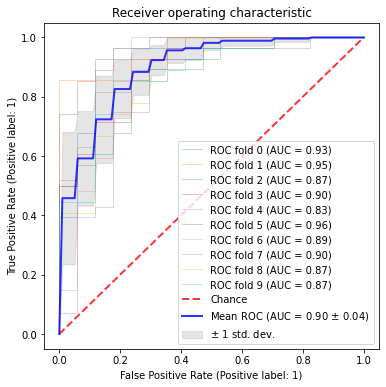

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.67791667 0.722875   0.73945833 0.7305     0.72629167 0.72808333
 0.70454167 0.74379167 0.717875   0.737625   0.745125   0.76116667
 0.74658333 0.72483333 0.70304167 0.733125   0.77108333 0.75275
 0.70229167 0.74841667 0.73279167 0.73029167 0.71254167 0.76441667
 0.72608333 0.73154167 0.73525    0.731875   0.73116667 0.72308333
 0.72954167 0.76183333 0.73875    0.760625   0.73933333 0.73054167
 0.707375   0.74133333 0.71470833 0.72

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.68070833 0.73216667 0.77275    0.73720833 0.71454167 0.71875
 0.72558333 0.749875   0.7435     0.75820833 0.75454167 0.75654167
 0.77120833 0.75016667 0.74675    0.78870833 0.75004167 0.77866667
 0.74591667 0.70804167 0.7145     0.721375   0.73308333 0.71220833
 0.72975    0.70954167 0.73879167 0.7775     0.74145833 0.737125
 0.75025    0.748625   0.718125   0.764125   0.76204167 0.75166667
 0.74545833 0.7425     0.69441667 0.6671

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.73533333 0.7155     0.74170833 0.70654167 0.72295833 0.73725
 0.73620833 0.74875    0.74316667 0.73691667 0.74933333 0.743625
 0.73570833 0.73658333 0.74704167 0.75104167 0.77725    0.75775
 0.71454167 0.76575    0.755875   0.71554167 0.71666667 0.75025
 0.722125   0.75241667 0.74566667 0.74933333 0.77891667 0.75616667
 0.769125   0.758125   0.76704167 0.75041667 0.758      0.76391667
 0.69579167 0.72654167 0.75266667 0.72120833 0

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.69625    0.76291667 0.77645833 0.765375   0.75445833 0.745375
 0.74629167 0.75333333 0.74004167 0.76654167 0.75420833 0.745625
 0.76983333 0.7695     0.7275     0.76520833 0.72791667 0.76370833
 0.7225     0.76066667 0.73016667 0.734375   0.77204167 0.78925
 0.73645833 0.752      0.79404167 0.74504167 0.77395833 0.74558333
 0.750375   0.74991667 0.75754167 0.759625   0.76691667 0.77741667
 0.73295833 0.755      0.7515     0.720208

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.74995833 0.768875   0.74916667 0.74025    0.78254167 0.748
 0.75475    0.78845833 0.757375   0.80091667 0.76479167 0.776625
 0.78175    0.80895833 0.794875   0.7985     0.78920833 0.78933333
 0.736      0.72275    0.760375   0.73825    0.76220833 0.74929167
 0.78408333 0.7675     0.77995833 0.76654167 0.75658333 0.769375
 0.772625   0.76345833 0.77025    0.77991667 0.78420833 0.79258333
 0.729      0.76058333 0.75845833 0.72925   

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.718625   0.73133333 0.75441667 0.7045     0.73241667 0.72979167
 0.7095     0.72091667 0.745      0.74925    0.744875   0.78058333
 0.75279167 0.74833333 0.759875   0.768375   0.771      0.76429167
 0.73358333 0.72054167 0.72029167 0.73829167 0.74716667 0.70270833
 0.70308333 0.72895833 0.75570833 0.73725    0.73358333 0.75883333
 0.73141667 0.73620833 0.73370833 0.77616667 0.77345833 0.77341667
 0.703625   0.71091667 0.74070833 0

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.70783333 0.71829167 0.74454167 0.73508333 0.70354167 0.72420833
 0.78120833 0.728625   0.741375   0.78658333 0.75679167 0.735125
 0.78191667 0.75516667 0.76908333 0.77266667 0.7705     0.754625
 0.68433333 0.69345833 0.736      0.740875   0.72358333 0.70941667
 0.74904167 0.749      0.747      0.76829167 0.76079167 0.75466667
 0.76145833 0.73295833 0.7475     0.78320833 0.74045833 0.758625
 0.70475    0.76604167 0.759625   0.752  

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.72720833 0.749875   0.75116667 0.7435     0.75066667 0.74575
 0.75908333 0.755625   0.7405     0.75958333 0.73570833 0.79291667
 0.77170833 0.74341667 0.756125   0.798375   0.76408333 0.75854167
 0.751625   0.72091667 0.75029167 0.75145833 0.73766667 0.733875
 0.74679167 0.76233333 0.7705     0.78075    0.78054167 0.76
 0.74895833 0.73654167 0.79254167 0.78191667 0.76458333 0.74683333
 0.707375   0.750875   0.74633333 0.72716667 0

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.71608333 0.735875   0.75183333 0.744125   0.73329167 0.733625
 0.762      0.74666667 0.74341667 0.77008333 0.767      0.747
 0.75916667 0.78983333 0.76816667 0.80466667 0.77895833 0.76704167
 0.691125   0.76883333 0.75029167 0.74695833 0.73895833 0.71479167
 0.756625   0.73904167 0.74966667 0.77766667 0.76054167 0.74245833
 0.75208333 0.76241667 0.78266667 0.82583333 0.745375   0.77895833
 0.73779167 0.74641667 0.74066667 0.713541

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.71175    0.74883333 0.73816667 0.74945833 0.75983333 0.74525
 0.76225    0.758      0.75225    0.759625   0.7415     0.76675
 0.76095833 0.75329167 0.75983333 0.78025    0.77358333 0.74758333
 0.74033333 0.70254167 0.74429167 0.74504167 0.74791667 0.73058333
 0.787625   0.7715     0.72579167 0.786375   0.76616667 0.76991667
 0.75158333 0.74475    0.75920833 0.775125   0.76516667 0.73429167
 0.73254167 0.738375   0.73133333 0.73254

Model 	 (mean, std, min, max)
precision_macro 0.8866 0.0646 0.8 1.0
recall_macro    0.7997 0.0583 0.6667 0.8571
specificity     0.8294 0.1034 0.7059 1.0
f1_macro        0.8393 0.0501 0.766 0.9231
accuracy        0.8111 0.0576 0.7273 0.9111
roc_auc         0.8837 0.0586 0.7836 0.9706
brier           0.1383 0.029 0.0902 0.1874


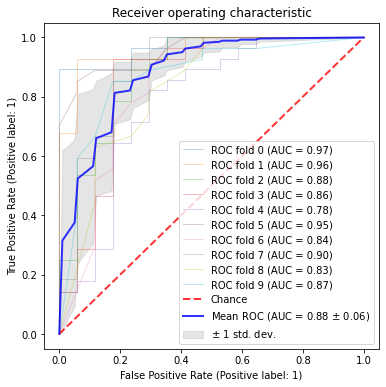

Model 	 (mean, std, min, max)
precision_macro 0.8729 0.0504 0.8065 1.0
recall_macro    0.8327 0.077 0.6667 0.8929
specificity     0.7941 0.0921 0.6471 1.0
f1_macro        0.8482 0.0335 0.766 0.8889
accuracy        0.8179 0.0313 0.75 0.8636
roc_auc         0.895 0.0429 0.8431 0.9769
brier           0.1317 0.0223 0.0897 0.1627


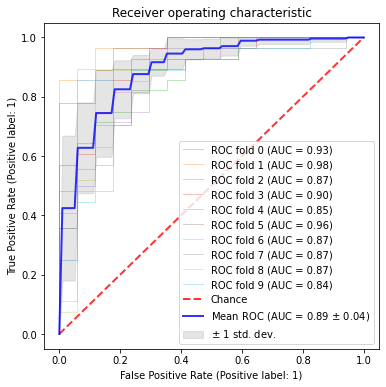

Model 	 (mean, std, min, max)
precision_macro 0.8645 0.0667 0.7857 1.0
recall_macro    0.88 0.0976 0.7037 1.0
specificity     0.7647 0.1262 0.5882 1.0
f1_macro        0.8672 0.0532 0.7857 0.9655
accuracy        0.8359 0.0619 0.7333 0.9556
roc_auc         0.9058 0.0469 0.813 0.9782
brier           0.1176 0.0251 0.0751 0.1666


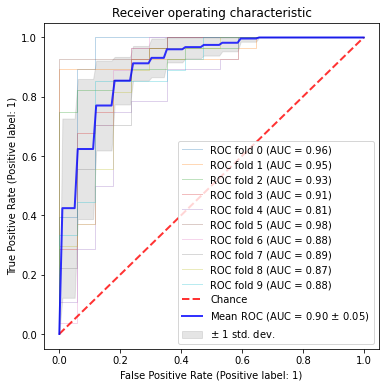

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.76792917 0.82418021 0.85338125 ... 0.88499167 0.87659583 0.87227917]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.89785213 0.89830173 0.93078955 ... 1.         1.         1.        ]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.83713021 0.82441042 0.86582083 ... 0.87066667 0.87355    0.86248125]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.90429505 0.90400592 0.93299307 ... 1.         1.         1.        ]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.83512083 0.81055417 0.89390938 ... 0.89861458 0.90130833 0.89730208]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.91849442 0.91391142 0.93696212 ... 1.         1.         1.        ]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.78763021 0.7790125  0.86291979 ... 0.89195208 0.87966458 0.88806875]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.90186345 0.89585595 0.92450738 ... 1.         1.         1.        ]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.81574792 0.78299479 0.86255938 ... 0.89270833 0.87916875 0.88327708]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.90063673 0.90332213 0.93014145 ... 1.         1.         1.        ]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.80772813 0.81305521 0.88402604 ... 0.88012708 0.8855375  0.88029583]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.90664035 0.90392378 0.93530029 ... 1.         1.         1.        ]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.80160729 0.80774271 0.87008333 ... 0.90025208 0.8956875  0.91918125]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.90236229 0.90549835 0.93894663 ... 1.         1.         1.        ]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.81363333 0.83025729 0.88919792 ... 0.87557708 0.90215    0.88723542]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the train scores are non-finite: [0.91114134 0.91310652 0.9326517  ... 1.         1.         1.        ]
  category=UserWarning
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Model 	 (mean, std, min, max)
precision_macro 0.859 0.0666 0.7857 1.0
recall_macro    0.8648 0.0855 0.7407 0.9643
specificity     0.7647 0.1116 0.6471 1.0
f1_macro        0.8592 0.058 0.7843 0.9643
accuracy        0.8265 0.0685 0.75 0.9556
roc_auc         0.8913 0.0516 0.7899 0.9769
brier           0.1383 0.0427 0.0734 0.2188


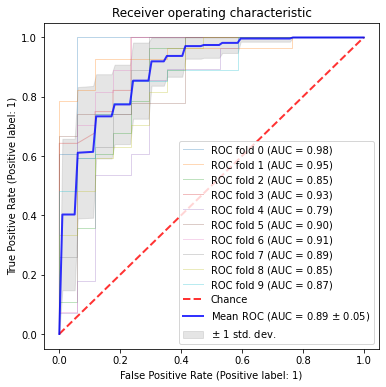

Model 	 (mean, std, min, max)
precision_macro 0.8728 0.0576 0.8214 1.0
recall_macro    0.8292 0.1053 0.5714 0.9286
specificity     0.7941 0.0958 0.7059 1.0
f1_macro        0.8443 0.0597 0.7273 0.9286
accuracy        0.8158 0.0582 0.7273 0.9111
roc_auc         0.8961 0.0473 0.8279 0.9782
brier           0.1293 0.0285 0.0718 0.1694


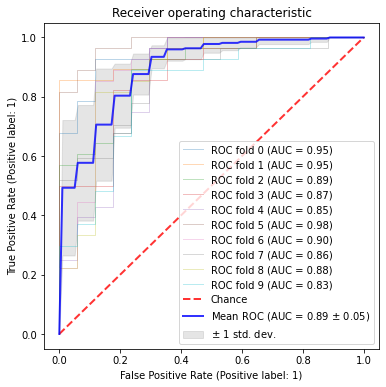

In [225]:
param_grids = [param_grid_lr,param_grid_knn,param_grid_gauss,param_grid_rf,param_grid_gbdt, param_grid_svm]
results_oversampling = dict.fromkeys(keys)

for idx, classifier in enumerate(clfs):
    results_oversampling[keys[idx]] = run_extended_oversampling_pipe(clfs[idx], param_grids[idx])

In [235]:
results_table_os = pd.DataFrame(columns = score_names, index=keys)

for model in keys:    
    for score in score_names:
        mean_score = round(np.array(results_oversampling[model]['scores'][score]).mean(), 2)
        results_table_os.loc[model][score] = mean_score

results_table_os

,roc_auc,accuracy,f1_macro,precision_macro,recall_macro,specificity,brier
lr,0.9,0.83,0.86,0.88,0.84,0.8,0.13
knn,0.88,0.81,0.84,0.89,0.8,0.83,0.14
gauss,0.89,0.82,0.85,0.87,0.83,0.79,0.13
rf,0.91,0.84,0.87,0.86,0.88,0.76,0.12
gbdt,0.89,0.83,0.86,0.86,0.86,0.76,0.14
svm,0.9,0.82,0.84,0.87,0.83,0.79,0.13


In [227]:
def run_fs6_oversampling_pipe(clf, param_grid):
    features = extended
    X = data[features].to_numpy()
    y = data['FASDjanein'].to_numpy()

    pipe = Pipeline([('scaler', sk.preprocessing.RobustScaler()),
                     ('imputer', KNNImputer(n_neighbors=2, weights="distance")),
                     ('oversampling', SMOTE(sampling_strategy=1.0)),
                     ('select_feats', ColumnTransformer([("fs", "passthrough", [0,3,6,8,10,12])], remainder="drop",)),
                     ('clf', clf)])
    results, estimators, probas, y_tests, confusion_matrices, fig = run_gs_pipe(X, y, pipe, param_grid)
    
    return_dict = {
        'scores' : results,
        'estimators' : estimators,
        'probas' : probas,
        'y_tests' : y_tests,
        'confusion_matrices': confusion_matrices,
        'fig' : fig   
    }
    
    return return_dict

Model 	 (mean, std, min, max)
precision_macro 0.8833 0.0573 0.7931 0.9565
recall_macro    0.8362 0.054 0.7143 0.9286
specificity     0.8118 0.1078 0.6471 0.9412
f1_macro        0.8566 0.032 0.8163 0.9286
accuracy        0.827 0.0399 0.7727 0.9111
roc_auc         0.9053 0.0465 0.8235 0.9727
brier           0.1261 0.0201 0.0792 0.1481


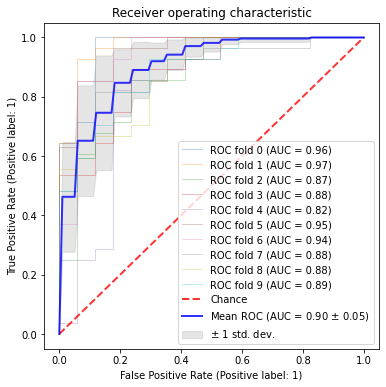

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.72616667 0.73254167 0.727375   0.73766667 0.727125   0.72929167
 0.72975    0.7395     0.73733333 0.72929167 0.72295833 0.746625
        nan        nan        nan        nan        nan        nan
 0.83981875 0.83714479 0.84105729 0.82212604 0.84623646 0.84522604
 0.82969479 0.84847396 0.83970625 0.81560833 0.8350375  0.83515521
        nan        nan        nan        nan        nan        nan
 0.86245    0.88195729 0.87319896 0.84453333 0.86818021 0.8688375
 0.86871979 0.86143854 0.86105937 0.85044375 0.85785208 0.85567813
        nan        nan        nan        nan        nan        nan
 0.87216354 0.88847187 0.87662813 0.84849896 0.87101667 0.86973021
 0.86193646 0.87362083 0.86954375 0.85155729 0.86090937 0.85424375
        nan        nan        nan     

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.77183333 0.78020833 0.78604167 0.77058333 0.786375   0.79
 0.78075    0.78783333 0.79391667 0.78608333 0.78033333 0.79391667
        nan        nan        nan        nan        nan        nan
 0.86446354 0.89205729 0.89033958 0.86025833 0.88254792 0.89243333
 0.86213854 0.88927604 0.8802625  0.85560521 0.88556458 0.89112396
        nan        nan        nan        nan        nan        nan
 0.87668229 0.89428646 0.90120937 0.87348854 0.897375   0.90662396
 0.86844375 0.90194479 0.89393542 0.87404583 0.89722917 0.89601354
        nan        nan        nan        nan        nan        nan
 0.87552292 0.89903958 0.90099896 0.88926667 0.89784271 0.90681562
 0.87053958 0.89657188 0.89010104 0.8735     0.90021146 0.89270313
        nan        nan        nan        

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.767625   0.78479167 0.78841667 0.77095833 0.78070833 0.7905
 0.77045833 0.771      0.788875   0.77225    0.771      0.794
        nan        nan        nan        nan        nan        nan
 0.87036667 0.86964896 0.87738646 0.87900521 0.87326875 0.87755208
 0.86335313 0.85957396 0.86143437 0.86599479 0.87195104 0.87007917
        nan        nan        nan        nan        nan        nan
 0.885825   0.89485104 0.8908375  0.87743333 0.89138854 0.88853333
 0.87780833 0.87694583 0.8846     0.88699062 0.8761625  0.88619792
        nan        nan        nan        nan        nan        nan
 0.88953958 0.89417187 0.89963542 0.8860375  0.89026562 0.89187812
 0.88368021 0.88270833 0.88012188 0.88505833 0.881075   0.88530208
        nan        nan        nan        nan

Model 	 (mean, std, min, max)
precision_macro 0.892 0.0532 0.8214 0.9615
recall_macro    0.8291 0.067 0.7037 0.8929
specificity     0.8294 0.0965 0.7059 0.9412
f1_macro        0.8564 0.038 0.8085 0.9259
accuracy        0.8293 0.0424 0.7778 0.9111
roc_auc         0.9013 0.0462 0.8141 0.9842
brier           0.1267 0.0279 0.0709 0.1678


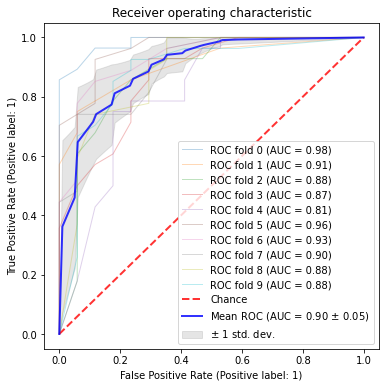

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


Model 	 (mean, std, min, max)
precision_macro 0.8731 0.0498 0.7931 0.9524
recall_macro    0.8402 0.0642 0.7143 0.8929
specificity     0.7941 0.0958 0.6471 0.9412
f1_macro        0.8533 0.0305 0.8077 0.9091
accuracy        0.8225 0.0339 0.7727 0.8889
roc_auc         0.9051 0.0501 0.8109 0.9748
brier           0.1224 0.0262 0.0688 0.1555


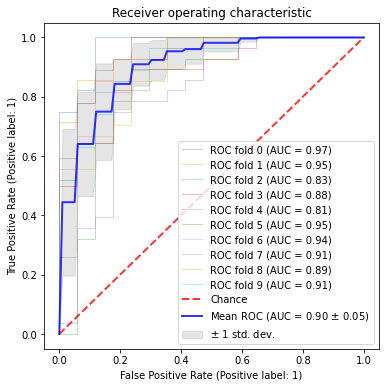

Model 	 (mean, std, min, max)
precision_macro 0.8938 0.0567 0.8125 1.0
recall_macro    0.8796 0.0748 0.7778 1.0
specificity     0.8235 0.1019 0.6471 1.0
f1_macro        0.8839 0.0447 0.8364 0.9655
accuracy        0.8583 0.0534 0.7955 0.9556
roc_auc         0.9147 0.0408 0.8298 0.9895
brier           0.1165 0.0275 0.0531 0.1557


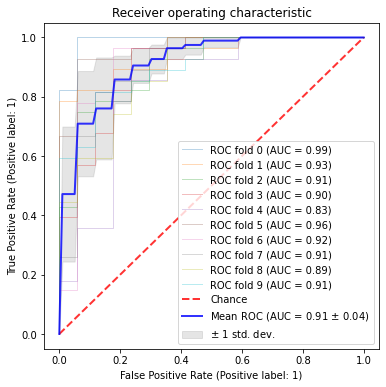

/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


/home/jupyter-lukas.ehrig/.local/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Model 	 (mean, std, min, max)
precision_macro 0.8859 0.0561 0.8214 1.0
recall_macro    0.8361 0.1066 0.6429 0.9643
specificity     0.8176 0.0965 0.7059 1.0
f1_macro        0.855 0.0601 0.75 0.9643
accuracy        0.8291 0.0623 0.7273 0.9556
roc_auc         0.9027 0.0567 0.8067 0.9853
brier           0.1342 0.0415 0.0526 0.1825


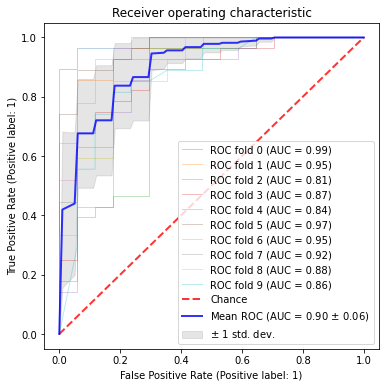

Model 	 (mean, std, min, max)
precision_macro 0.8776 0.0525 0.7931 0.95
recall_macro    0.8183 0.0575 0.6786 0.8929
specificity     0.8059 0.1021 0.6471 0.9412
f1_macro        0.844 0.0286 0.7917 0.8889
accuracy        0.8136 0.0327 0.7727 0.8667
roc_auc         0.9012 0.0442 0.834 0.9685
brier           0.1279 0.0232 0.079 0.1551


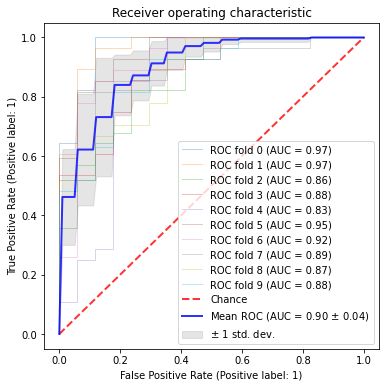

In [228]:
param_grids = [param_grid_sf_lr,param_grid_sf_knn,param_grid_sf_gauss,param_grid_sf_rf,param_grid_sf_gbdt, param_grid_sf_svm]
results_oversampling_fs6 = dict.fromkeys(keys)

for idx, classifier in enumerate(clfs):
    results_oversampling_fs6[keys[idx]] = run_fs6_oversampling_pipe(clfs[idx], param_grids[idx])

In [234]:
results_table_fs6_os = pd.DataFrame(columns = score_names, index=keys)

for model in keys:    
    for score in score_names:
        mean_score = round(np.array(results_oversampling_fs6[model]['scores'][score]).mean(), 2)
        results_table_fs6_os.loc[model][score] = mean_score

results_table_fs6_os

,roc_auc,accuracy,f1_macro,precision_macro,recall_macro,specificity,brier
lr,0.91,0.83,0.86,0.88,0.84,0.81,0.13
knn,0.9,0.83,0.86,0.89,0.83,0.83,0.13
gauss,0.91,0.82,0.85,0.87,0.84,0.79,0.12
rf,0.91,0.86,0.88,0.89,0.88,0.82,0.12
gbdt,0.9,0.83,0.86,0.89,0.84,0.82,0.13
svm,0.9,0.81,0.84,0.88,0.82,0.81,0.13


# Comparison of Results

In [239]:
results_table

,roc_auc,accuracy,f1_macro,precision_macro,recall_macro,specificity,brier
lr,0.91,0.84,0.86,0.89,0.84,0.82,0.12
knn,0.9,0.84,0.87,0.87,0.88,0.77,0.12
gauss,0.9,0.84,0.87,0.86,0.89,0.75,0.12
rf,0.92,0.85,0.88,0.86,0.91,0.76,0.11
gbdt,0.91,0.85,0.88,0.86,0.91,0.75,0.12
svm,0.9,0.85,0.88,0.85,0.92,0.74,0.12


In [241]:
results_table_fs6

,roc_auc,accuracy,f1_macro,precision_macro,recall_macro,specificity,brier
lr,0.9,0.82,0.84,0.89,0.81,0.82,0.13
knn,0.91,0.84,0.87,0.87,0.88,0.77,0.11
gauss,0.91,0.83,0.86,0.86,0.88,0.76,0.12
rf,0.93,0.85,0.88,0.87,0.91,0.76,0.11
gbdt,0.91,0.84,0.87,0.87,0.87,0.78,0.12
svm,0.9,0.84,0.87,0.85,0.91,0.73,0.12


In [242]:
results_table_os

,roc_auc,accuracy,f1_macro,precision_macro,recall_macro,specificity,brier
lr,0.9,0.83,0.86,0.88,0.84,0.8,0.13
knn,0.88,0.81,0.84,0.89,0.8,0.83,0.14
gauss,0.89,0.82,0.85,0.87,0.83,0.79,0.13
rf,0.91,0.84,0.87,0.86,0.88,0.76,0.12
gbdt,0.89,0.83,0.86,0.86,0.86,0.76,0.14
svm,0.9,0.82,0.84,0.87,0.83,0.79,0.13


In [244]:
results_table_fs6_os

,roc_auc,accuracy,f1_macro,precision_macro,recall_macro,specificity,brier
lr,0.91,0.83,0.86,0.88,0.84,0.81,0.13
knn,0.9,0.83,0.86,0.89,0.83,0.83,0.13
gauss,0.91,0.82,0.85,0.87,0.84,0.79,0.12
rf,0.91,0.86,0.88,0.89,0.88,0.82,0.12
gbdt,0.9,0.83,0.86,0.89,0.84,0.82,0.13
svm,0.9,0.81,0.84,0.88,0.82,0.81,0.13
